# 🔍 LLM Benchmarking with Azure OpenAI and DeepSeek
 
This notebook benchmarks various large language models (LLMs) across multiple scenarios.
You can test models deployed via Azure AI Foundry, Azure OpenAI, or directly via OpenAI/GitHub.

## 📦 Step 1: Install Dependencies
Install all required libraries for inference and visualization.

In [17]:
# !pip install -r requirements.txt

## 📁 Step 2: Load Environment Variables
Load all authentication credentials and endpoint URLs from the `.env` file.

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

True

## 📚 Step 3: Import Libraries
We import inference clients, plotting tools, and utility packages.

In [2]:
from azure.ai.inference import ChatCompletionsClient
from azure.ai.inference.models import SystemMessage, UserMessage
from azure.core.credentials import AzureKeyCredential
from openai import AzureOpenAI, OpenAI
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

## 🔐 Step 4: Set Up Clients
Connect to Azure AI Inference, Azure OpenAI, and OpenAI using your API keys and endpoints.

In [4]:
client4 = ChatCompletionsClient(endpoint="https://models.inference.ai.azure.com", credential=AzureKeyCredential(os.environ["GITHUB_TOKEN"]))

## 🧠 Step 5: Define Models and Prompts
List the models and define scenarios to evaluate their performance.

In [5]:
# Define models to compare
MODELS = ["gpt-4o","DeepSeek-V3"]
    
# Test Prompts for different scenarios
TEST_PROMPTS = {
    "General Q&A": "What is the capital of Canada?",
    "Coding Task": "Write a Python function to check if a number is prime.",
    "Math Problem": "Solve the equation: 2x + 3 = 11",
    "Logical Reasoning": "If all birds can fly and an eagle is a bird, can an eagle fly?",
    "Creative Writing": "Write a short sci-fi story about a robot discovering emotions.",
    "Multi-turn Conversation": "User: Tell me a joke.\nAI: [response]\nUser: Explain why it's funny."
}

## 🧪 Step 6: Define Model Call Functions
Functions to call each model depending on the client they belong to.

In [6]:
def call_github_model(model, prompt):
    try:
        # Create a list of messages for the chat
        messages = [
            SystemMessage(content=f"You are an AI assistant that helps people find information."),
            UserMessage(content=prompt)
        ]
        start_time = time.time()
        # Call the Azure Inference SDK
        response = client4.complete(
            messages=messages,
            model=model,
            temperature=1,
            max_tokens=4096,
            top_p=1
        )
        end_time = time.time()

        response_text = response.choices[0].message.content
        token_usage = response.usage.total_tokens

        # Extract and return the response content
        return response_text.strip(), token_usage, end_time - start_time
    except Exception as e:
        print(f"Error calling model {model}: {e}")
        return None, 0, 0

## 🚀 Step 7: Run Benchmark
Iterate over all tasks and models, calling the appropriate function and collecting results.

In [7]:
def benchmark_models():
    results = []
    for scenario, prompt in TEST_PROMPTS.items():
        for model_name in MODELS:
            response, tokens, time_taken = call_github_model(model_name, prompt)
            results.append({
                "Scenario": scenario,
                "Model": model_name,
                "Response Time (s)": round(time_taken, 3),
                "Token Usage": tokens,
                "Response": response[:200] if response else "Error"
            })
            time.sleep(5)  # To avoid hitting rate limits
    
    df = pd.DataFrame(results)
    return df

## 📊 Step 8: Visualize Results
Create bar plots to compare performance across models by response time and token usage.

In [8]:
def visualize_results(df):
    fig, axes = plt.subplots(3, 2, figsize=(18, 16))

    sns.barplot(data=df, x="Model", y="Response Time (s)", hue="Scenario", ax=axes[0, 0])
    axes[0, 0].set_title("Response Time Comparison")
    axes[0, 0].tick_params(axis='x', rotation=45)

    sns.barplot(data=df, x="Model", y="Token Usage", hue="Scenario", ax=axes[0, 1])
    axes[0, 1].set_title("Token Usage Comparison")
    axes[0, 1].tick_params(axis='x', rotation=45)

    sns.boxplot(data=df, x="Model", y="Response Time (s)", ax=axes[1, 0])
    axes[1, 0].set_title("Response Time Variability")
    axes[1, 0].tick_params(axis='x', rotation=45)

    sns.boxplot(data=df, x="Model", y="Token Usage", ax=axes[1, 1])
    axes[1, 1].set_title("Token Usage Variability")
    axes[1, 1].tick_params(axis='x', rotation=45)

    heatmap_rt = df.pivot_table(index="Scenario", columns="Model", values="Response Time (s)")
    sns.heatmap(heatmap_rt, annot=True, cmap="coolwarm", linewidths=0.5, ax=axes[2, 0])
    axes[2, 0].set_title("Heatmap: Response Time")

    heatmap_tokens = df.pivot_table(index="Scenario", columns="Model", values="Token Usage")
    sns.heatmap(heatmap_tokens, annot=True, cmap="coolwarm", linewidths=0.5, ax=axes[2, 1])
    axes[2, 1].set_title("Heatmap: Token Usage")

    plt.tight_layout()
    plt.show()

## ✅ Step 9: Run and Review
Run the benchmark and display a preview of the results.

In [9]:
df_results = benchmark_models()

In [10]:
display(df_results)

,Scenario,Model,Response Time (s),Token Usage,Response
0,General Q&A,gpt-4o,0.786,40,The capital of Canada is **Ottawa**.
1,General Q&A,DeepSeek-V3,0.884,60,"The capital of Canada is **Ottawa**, which is ..."
2,Coding Task,gpt-4o,12.290,391,Sure! Here's a Python function to check if a n...
3,Coding Task,DeepSeek-V3,4.871,390,Certainly! Below is a Python function that che...
4,Math Problem,gpt-4o,4.108,152,"To solve the equation \( 2x + 3 = 11 \), follo..."
5,Math Problem,DeepSeek-V3,1.714,140,"To solve the equation \( 2x + 3 = 11 \), follo..."
6,Logical Reasoning,gpt-4o,1.525,86,"Yes, if the statement that ""all birds can fly""..."
7,Logical Reasoning,DeepSeek-V3,1.165,99,"Yes, if all birds can fly and an eagle is a bi..."
8,Creative Writing,gpt-4o,19.258,1099,**The Spark Within**\n\nOn the distant planet ...
9,Creative Writing,DeepSeek-V3,9.144,745,**Title: The Awakening of Unit-7**\n\nIn the y...


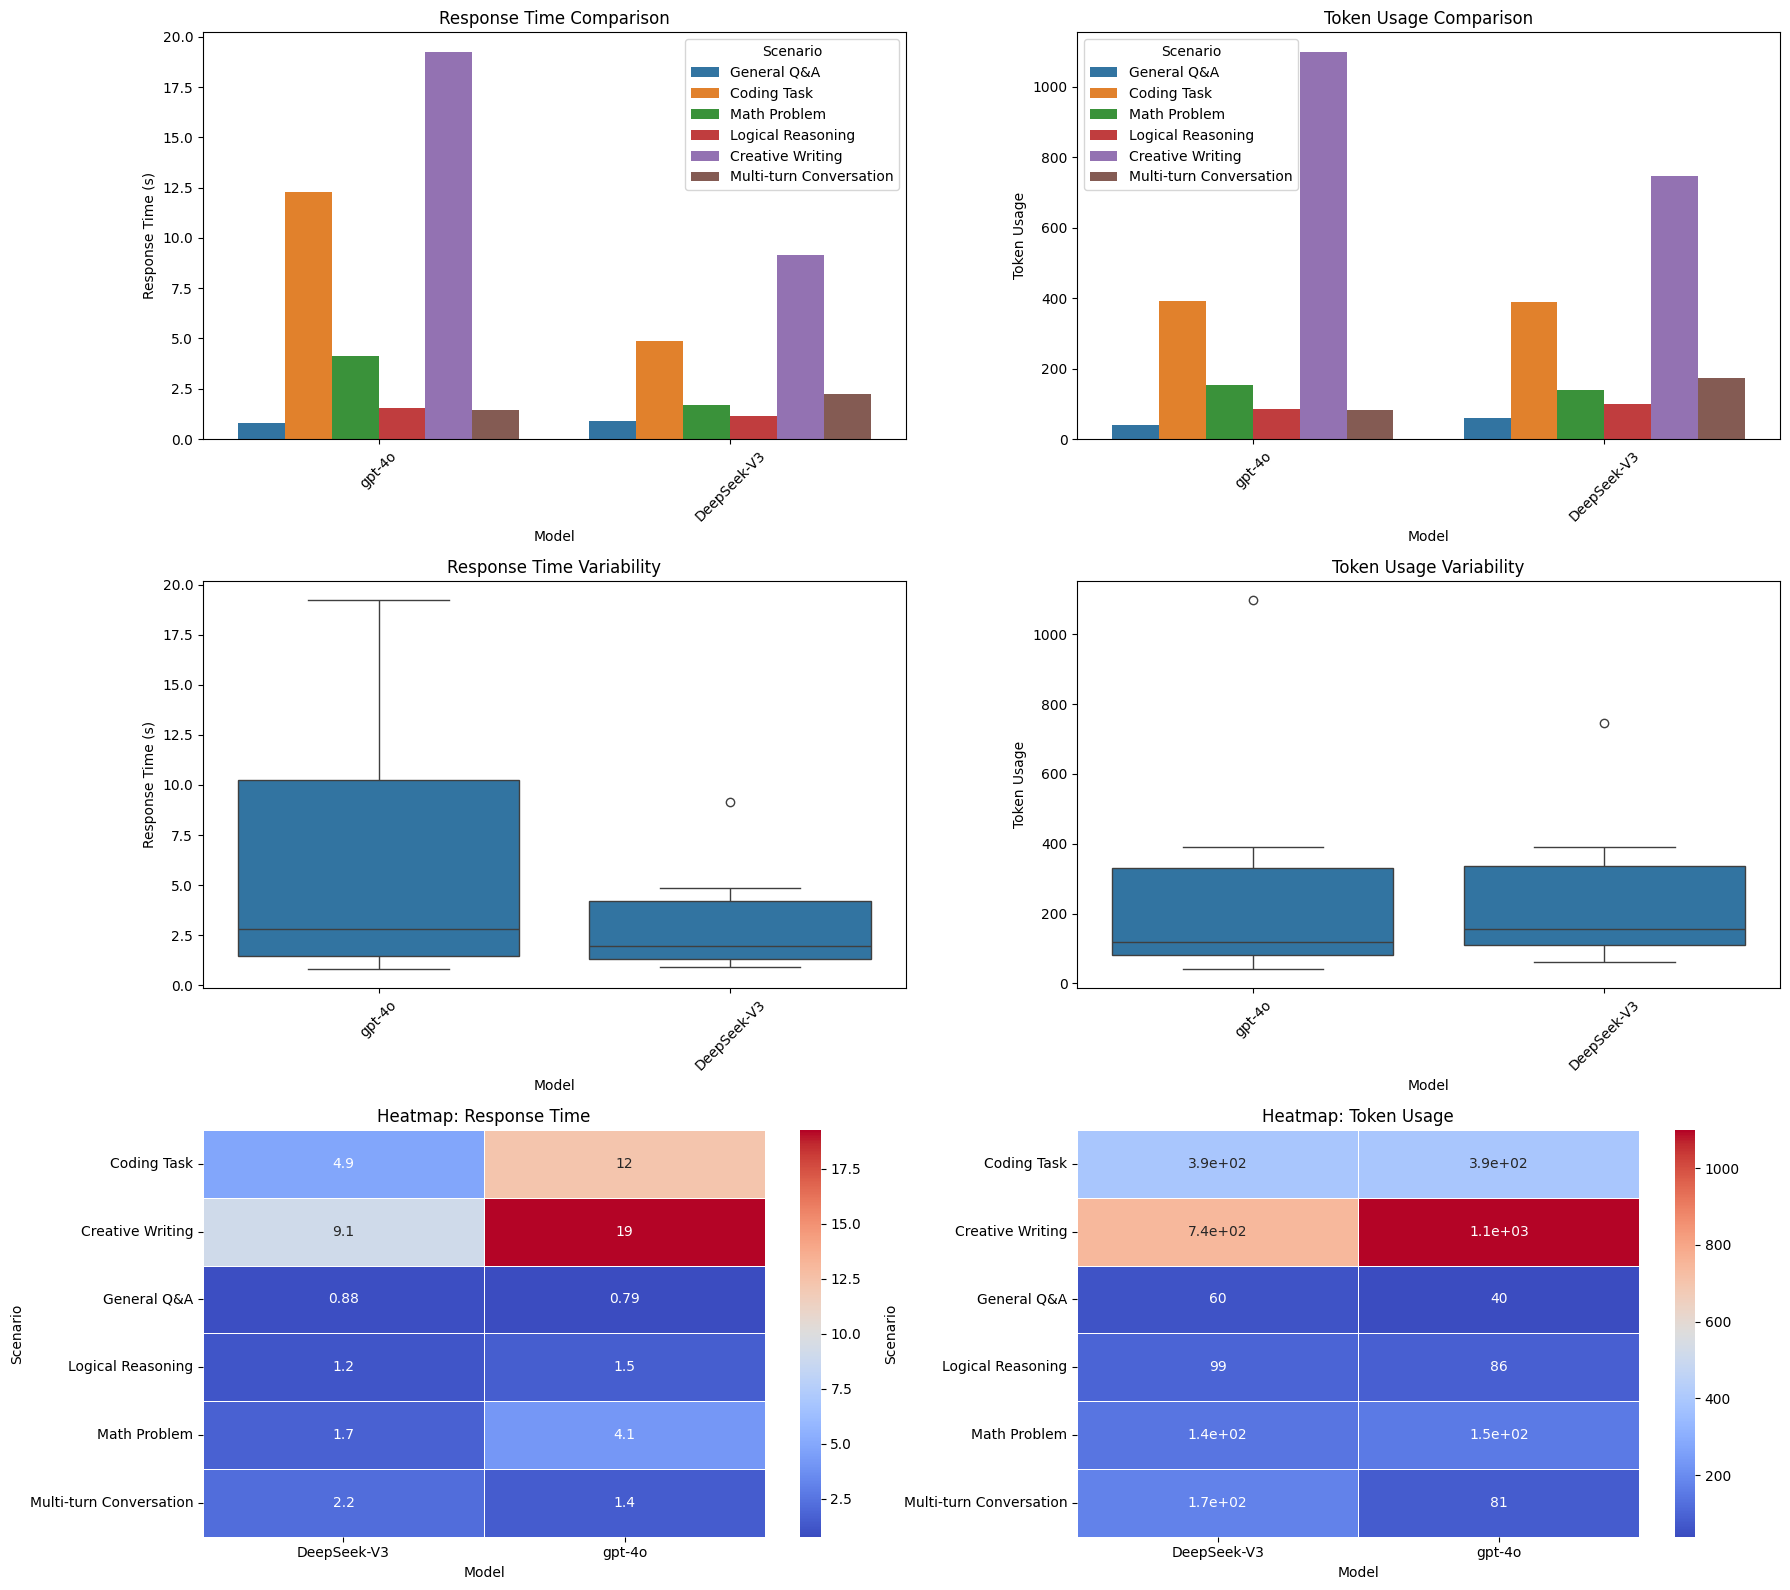

In [11]:
visualize_results(df_results)